In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import RocCurveDisplay

In [2]:
# Global variables
DATASET_PATH = "D:/flight dataset/"

intr_cols = [
    "Origin", "Dest", "Cancelled", "DepTime",
    "DepDelayMinutes", "Distance", "Month", "DayofMonth",
    "DayOfWeek", "DOT_ID_Operating_Airline", "Tail_Number", "Flight_Number_Operating_Airline",
    "WheelsOff", "TaxiOut",
    "Year",
    #"FlightDate",
    #"Diverted",
    #"ArrTime",
    #"ArrDelayMinutes",
    #"AirTime",
    #"ActualElapsedTime",
    #"Operating_Airline",
    #"OriginCityName",
    #"OriginStateName",
    #"OriginWac",
    #"DestCityName",
    #"DestStateName",
    #"DestWac",
    #"WheelsOn",
    #"Airline",
    #"TaxiIn",
    #"DivAirportLandings"
]

In [3]:
# Utility functions

# Load all dataframes
def loadAll(lstFiles, lstCol=intr_cols):
    if type(lstFiles) != list:
        lstFiles = [lstFiles]
    df = pd.DataFrame({})
    for dataFile in tqdm(lstFiles):
        dfTemp = pd.read_csv(DATASET_PATH + dataFile)
        dfTemp = dfTemp[lstCol]
        df = pd.concat([df, dfTemp], ignore_index=True)
        del dfTemp
    return df

def writeJson(obj, fileName):
    with open(fileName, "w") as write_file:
        json.dump(obj, write_file, indent=4)

def readJson(fileName):
    f = open(fileName)
    obj = json.load(f)
    f.close()
    return obj

# Dataset Analysis

In [ ]:
# Plotting functions

# Correlation plot
def plotCorr(df):
    plt.figure(figsize=(11,8))
    sns.heatmap(df.corr(), annot=True)
    #sns.pairplot(df)
    plt.show()

# BAR PLOT: delays
def plotDelayType(df, title):
    onTimeDf = df.query("DepDelayMinutes == 0").size
    smallDelay = df.query("DepDelayMinutes > 0 & DepDelayMinutes <= 15").size
    mediumDelay = df.query("DepDelayMinutes > 15  & DepDelayMinutes <= 30").size
    largeDelay = df.query("DepDelayMinutes > 30").size

    plt.bar(["On Time", "Small Delay", "Medium Delay", "Large Delay"], [onTimeDf, smallDelay, mediumDelay, largeDelay], color = ["purple", "violet", "slateblue", "royalblue"])
    plt.title(title)
    plt.show()

# BAR PLOT: Average Delay by Week
def weeklyDelay(df, title):
    daily = []
    weekRange = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    for x in range(1, len(weekRange) + 1):
        dailyDf = df.query(f"DayOfWeek == {x}")
        daily.append(dailyDf["DepDelayMinutes"].sum() / dailyDf.size)

    plt.bar(weekRange, daily, color = ["springgreen", "lightgreen", "mediumseagreen", "limegreen", "seagreen",  "forestgreen",  "darkgreen"])
    plt.title(title)
    plt.show()

# State Delay Chart
def plotStateDelay(df, title):
    groupDf = df[["DepDelayMinutes", "OriginStateName"]].groupby(["OriginStateName"])
    joined = groupDf.sum().merge(groupDf.size().rename("size"), left_index=True, right_index=True)
    avgDelState = joined["DepDelayMinutes"] / joined["size"]
    avgDelState = avgDelState.sort_values(ascending=True)
    plt.figure(figsize=(5,10))
    avgDelState.plot.barh(color="teal")
    plt.title(title)
    plt.show()

In [ ]:
df = loadAll("Combined_Flights_2018.csv")
df.drop("Cancelled", axis=1, inplace=True)
plotCorr(df)

In [ ]:
lstCol = ["DepDelayMinutes", "DayOfWeek", "OriginStateName"]
files = ["Combined_Flights_2018.csv", "Combined_Flights_2019.csv", "Combined_Flights_2021.csv", "Combined_Flights_2022.csv"]
df2020 = loadAll("Combined_Flights_2020.csv", lstCol)
df = loadAll(files, lstCol)

In [ ]:
plotDelayType(df, "Type of Delay\n2020 excluded")
plotDelayType(df2020, "Type of Delay 2020")

In [ ]:
weeklyDelay(df, "Average Delay by Week\n2020 excluded")
weeklyDelay(df2020, "Average Delay by Week 2020")

In [ ]:
plotStateDelay(df, "States Delay chart")

# Dataset Preprocessing

In [4]:
# Dataset preprocessing
files = ["Combined_Flights_2018.csv", "Combined_Flights_2019.csv", "Combined_Flights_2020.csv", "Combined_Flights_2021.csv", "Combined_Flights_2022.csv"]
df = loadAll(files, intr_cols)

# Remove cancelled flight
df = df[df["Cancelled"] == False].drop("Cancelled", axis=1, inplace=False)
df.dropna(inplace=True)

# Encode str to int32 
leAirport = LabelEncoder()
leTail = LabelEncoder()
leAirport.fit(np.unique(df[["Origin", "Dest"]].values.reshape(1, -1)))
df["Origin"] = leAirport.transform(df["Origin"])
df["Dest"] = leAirport.transform(df["Dest"])
df["Tail_Number"] = leTail.fit_transform(df["Tail_Number"])

# Encode delayed result
# To do later
# df["DepDelayMinutes"] = (df["DepDelayMinutes"] > 15).astype("int")

# Track 2020
df["Year"] = df["Year"] == 2020
sample_weight = df["Year"].values
df.drop("Year", inplace=False, axis=1);

100%|██████████| 5/5 [02:08<00:00, 25.66s/it]


In [5]:
# Split dataset
y = df["DepDelayMinutes"].values
X = df.drop("DepDelayMinutes", inplace=False, axis = 1).values
features_name = list(df.drop("DepDelayMinutes", inplace=False, axis = 1).columns.values)
del df
print("Splitting")
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X, y, sample_weight, test_size = 0.25, random_state = 0)
# Scaling values
print("Scaling")
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Splitting
Scaling


# Logistic Regression

In [ ]:
# Train Logistic Regression model foreach
# Standard solver was slow to converge

#Encode delayed results
delay = 15
y_train_tmp = (y_train > delay).astype("int")
y_test_tmp =(y_test > delay).astype("int")
lstReport = {}
for w in tqdm(np.array(range(0, 110, 10)) / 100):
    classifier = LogisticRegression(solver="newton-cholesky", random_state=0, n_jobs=-1)
    sw_train_temp = (sw_train * w) + (sw_train == 0)
    classifier = classifier.fit(X_train, y_train_tmp, sample_weight=sw_train_temp)
    y_pred = classifier.predict(X_test)
    lstReport[w] = classification_report(y_test_tmp, y_pred, output_dict=True)
    RocCurveDisplay.from_estimator(classifier, X_test, y_test_tmp)
    plt.title(f"Weight: {round(w, 2)}")
    plt.savefig(f"./ROC_{round(w, 2)}.png")

writeJson(lstReport, "logistic_weighted2.json")

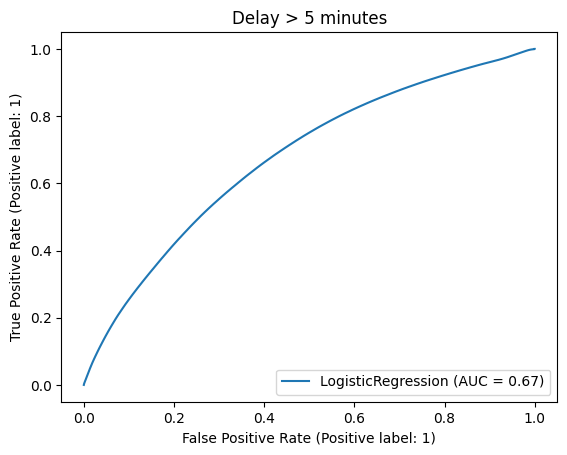

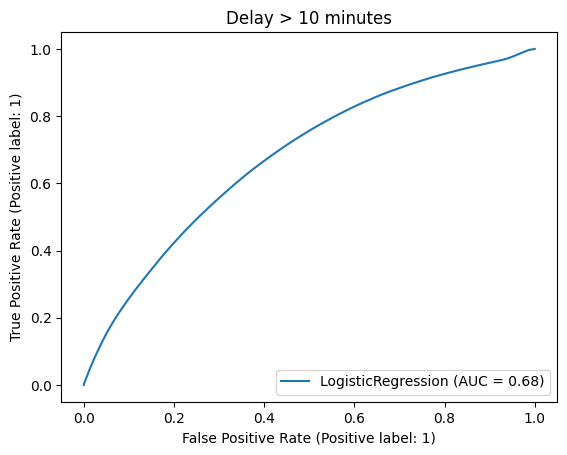

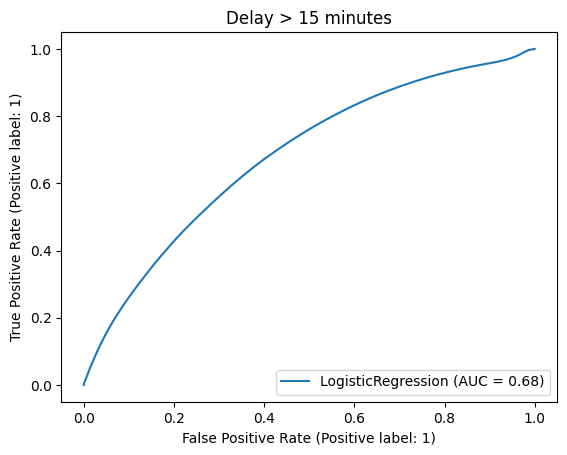

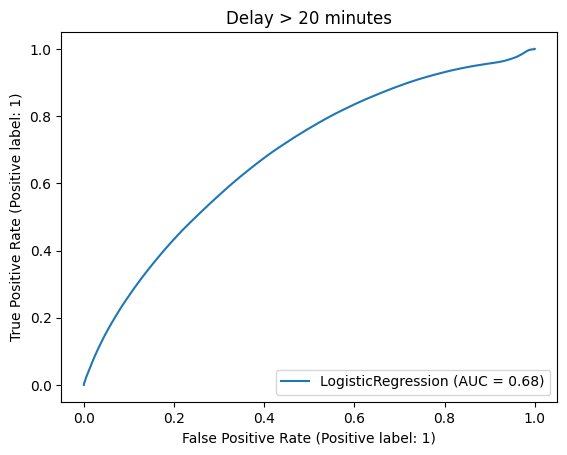

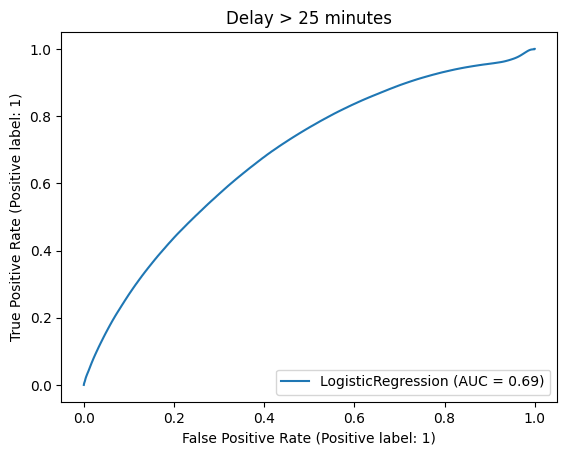

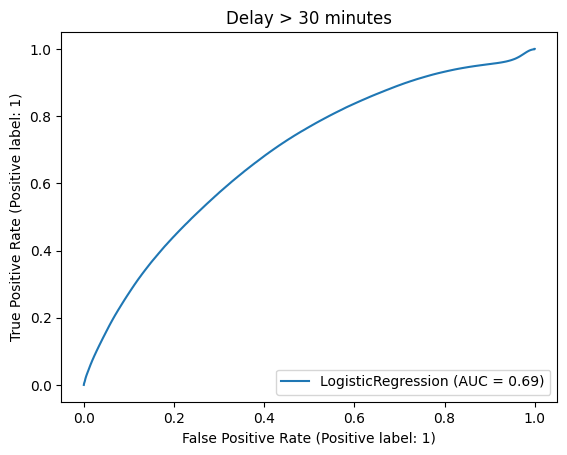

In [6]:
lstReport = {}
for d in tqdm(range(5, 35, 5)):
    y_train_tmp = (y_train > d).astype("int")
    y_test_tmp =(y_test > d).astype("int")
    classifier = LogisticRegression(solver="newton-cholesky", random_state=0, n_jobs=-1)
    classifier = classifier.fit(X_train, y_train_tmp)
    y_pred = classifier.predict(X_test)
    lstReport[d] = classification_report(y_test_tmp, y_pred, output_dict=True)
    RocCurveDisplay.from_estimator(classifier, X_test, y_test_tmp)
    plt.title(f"Delay > {d} minutes")
    plt.savefig(f"./ROC_{d}.png")

writeJson(lstReport, "logistic_delayed2.json")

In [ ]:
classifier = LogisticRegression(solver="newton-cholesky", random_state=0, n_jobs=-1)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
RocCurveDisplay.from_estimator(classifier, X_test, y_test)

In [ ]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Accuracy : ", accuracy_score(y_test, y_pred))
print(cm)
print(classifier.coef_)
# Hanno più influenza DepTime, Distance and taxiOut
print(np.std(X, 0)*classifier.coef_)
# Plot ROC
RocCurveDisplay.from_estimator(classifier, X_test, y_test)

# Decision Tree

In [ ]:
# Decision Tree model
dModel = DecisionTreeClassifier(n_jobs=-1)
dModel.fit(X_train, y_train)

In [ ]:
lstReport = {}
for d in tqdm(range(5, 35, 5)):
    y_train_tmp = (y_train > d).astype("int")
    y_test_tmp =(y_test > d).astype("int")
    classifier = DecisionTreeClassifier(solver="newton-cholesky", random_state=0, n_jobs=-1)
    classifier = classifier.fit(X_train, y_train_tmp)
    y_pred = classifier.predict(X_test)
    lstReport[d] = classification_report(y_test_tmp, y_pred, output_dict=True)
    RocCurveDisplay.from_estimator(classifier, X_test, y_test_tmp)
    plt.title(f"Delay > {d} minutes")
    plt.savefig(f"./ROC_{d}.png")

writeJson(lstReport, "decision_delayed.json")

In [ ]:
#y_pred = dModel.predict_proba(X_test)
RocCurveDisplay.from_estimator(dModel, X_test, y_test)

# K-Nearest Neighbors

In [ ]:
# subsampling data
num_training = 10000
X_train_sub = X_train[:num_training]
y_train_sub = y_train[:num_training]

k_range = range(5, 11)
scores = {}
scores_list = []

In [ ]:
for k in tqdm(k_range):
    kCl = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    kFit = kCl.fit(X_train_sub, y_train_sub)
    pred = kFit.predict(X_test)
    scores[k] = pred
    correct = (pred == y_test).sum()
    scores_list.append(correct / y_train_sub.shape[0])

In [ ]:
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
# now pick the best k and train on the whole training set
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
# print the accuracy
print(metrics.accuracy_score(y_test, y_pred))